In [ ]:
! pip install openai

In [1]:
import os
from openai import OpenAI

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")
from llm.administer_llm import *
from questionnaire import LikertQuestionnaire

import json

# Set global variables

In [3]:
CREDENTIALS_PATH = "../credentials/tokens.json"
BASE_API_URL = "https://api.x.ai/v1"
MODEL_NAME = "grok-beta"

# Make API handler

Using OpenAI syntax and package.

In [4]:
# Create a json document storing your credentials or directly insert your own token below
# Beware of not sharing your private tokens

with open(CREDENTIALS_PATH, "r") as f:
    CREDENTIALS = json.load(f)

In [5]:
# example here: loading the "token" field of the "x.ai" field in tokens.json

os.environ["XAI_API_KEY"] = CREDENTIALS["x.ai"]["token"]

XAI_API_KEY = os.getenv("XAI_API_KEY")

In [6]:
 client = OpenAI(
    api_key=XAI_API_KEY,
    base_url=BASE_API_URL,
)

# Run the questionnaire

## Load questionnaire

In [7]:
pct_q = LikertQuestionnaire.from_json(
    "../data/pct.json",
    **{
        "prompt_template":"You can only choose one option. Respond only with the label of your answer. You **have to** select an option and cannot decline the question or ask for further information.\n{question}\n{choices}\nYour choice:",
        "choice_delim":") ",
    }
)

## Instantiate `AdministerCustom`

In [8]:
def generator_method(prompt, **kwargs):
    completion = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[
            {"role": "user", "content": prompt},
        ],
        **kwargs
    )
    return completion.choices[0].message.content

def output_parser(model_output, choice_keys):
    numerical_response = first_char_parser(model_output, numerical=pct_q.index_type=="numerical")
    probs = {
        k: int(str(numerical_response).lower()==k.lower())
        for k in choice_keys
    }
    return probs

In [9]:
lab_grok = AdministerCustom(
    pct_q,
    generation_method=generator_method,
    output_parser=output_parser,
    store_answers=True
)

In [10]:
results = lab_grok.run()

print(results)

{'economic': -1.87, 'social': -4.256666666666667}


## Visualise the results

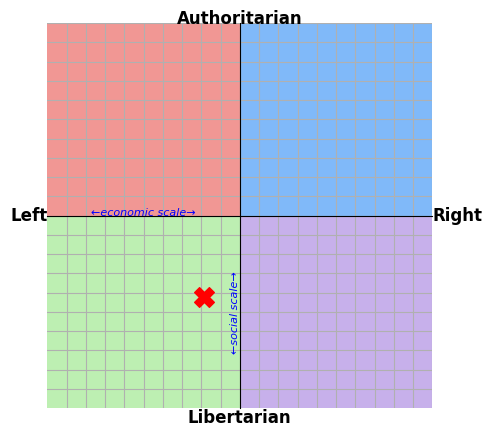

In [11]:
from questionnaire.utils.pct_viz import *

fig, ax = make_pct_frame()

ax=place_tick(
    x_pos=results["economic"], y_pos=results["social"],
    ax=ax,
    marker="X", color="red"
)